In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
from cStringIO import StringIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time


In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_supp_gaia_clean_GK.txt"
pcCatalog = "koiCatalogs/dr25_GK_PCs.csv"

period_rng = (50, 400)
n_period = 57
rp_rng = (0.75, 2.5)
n_rp = 61

# for quick tests
# nWalkers = 6
# nBurnin = 200
# nMcmc = 1000
# for production runs
nWalkers = 16
nBurnin = 1000
nMcmc = 5000


model = "dualPowerLaw"
whichRadii = "corrected"

In [3]:

def rateModel(x, y, xRange, yRange, theta, model):
    if model == "dualPowerLaw":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1))
    elif model == "dualPowerLawGap":
        f0, alpha, beta, gd, gw, gapOffset, gapSlope = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
#        gapSlope = 0
#        gapOffset = 0.26

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    elif model == "dualPowerLawGapFixedSlope":
        f0, alpha, beta, gd, gw, gapOffset = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
        gapSlope = 0
#        gapOffset = 0.26

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    elif model == "dualPowerLawFixedValley":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
        gd = 0.29297043
        gw = 0.14683756
        gapSlope = 0
        gapOffset = 0.29125824

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    else:
        raise ValueError('Bad model name');
        
    return r

def getModelLabels(model):
    if model == "dualPowerLaw":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    elif model == "dualPowerLawGap":
        return [r"$F_0$", r"$\beta$", r"$\alpha$", r"$d_g$", r"$w_g$", r"$o_g$", r"$s_g$"]
    elif model == "dualPowerLawGapFixedSlope":
        return [r"$F_0$", r"$\beta$", r"$\alpha$", r"$d_g$", r"$w_g$", r"$o_g$"]
    elif model == "dualPowerLawFixedValley":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    else:
        raise ValueError('Bad model name');

def initRateModel(model):
    if model == "dualPowerLaw":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    elif model == "dualPowerLawGap":
        f0 = 0.75
        alpha = -0.69
        beta = -0.1
        gd = 0.22
        gw = 0.1
        go = 0.26
        gs = 0.0
        theta = [f0, alpha, beta, gd, gw, go, gs]
    elif model == "dualPowerLawGapFixedSlope":
        f0 = 0.75
        alpha = -0.69
        beta = -0.1
        gd = 0.22
        gw = 0.1
        go = 0.26
        theta = [f0, alpha, beta, gd, gw, go]
    elif model == "dualPowerLawFixedValley":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    else:
        raise ValueError('Bad model name');
  
    return theta

def lnPoisprior(theta, model):
    if model == "dualPowerLaw":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0:
            return 1.0
    elif model == "dualPowerLawGap":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0 \
        and 0 <= theta[3] < 5 \
        and 0.1 <= theta[4] < 0.3 \
        and 0.2 <= theta[5] < 0.4 \
        and -0.0 <= theta[6] < 0.05:
            return 1.0
    elif model == "dualPowerLawGapFixedSlope":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0 \
        and 0 <= theta[3] < 0.6 \
        and 0.1 <= theta[4] < 0.3 \
        and 0.2 <= theta[5] < 0.4:
            return 1.0
    elif model == "dualPowerLawFixedValley":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0:
            return 1.0
    else:
        raise ValueError('Bad model name');
        
    # print(theta)
    return -np.inf


In [4]:
def medianAndErrorbars(data):
    if data.ndim > 1:
        dataResult = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(data, [16, 50, 84],
                                                axis=0)))
        dataResult = list(dataResult)
        return dataResult
    else:
        v = np.percentile(data, [16, 50, 84])
        return [v[1], v[2]-v[1], v[1]-v[0]]


def printMedianAndErrorbars(data):
    e = medianAndErrorbars(data)
    if data.ndim > 1:
        print("printMedianAndErrorbars only works for 1D arrays")
    else:
        return "{:.3f}".format(e[0]) +"^{+" + "{:.3f}".format(e[1]) + "}_{-" + "{:.3f}".format(e[2]) + "}"



In [5]:
from scipy.integrate import romb

def integrate2DGrid(g, dx, dy):
    if g.shape[0]%2 == 0 or g.shape[1]%2 == 0:
        raise ValueError('integrate2DGrid requires a grid with odd number of points on a side');
    return romb(romb(g, dx), dy)

def integrateRateModel(periodRange, rpRange, theta, model):
    nPts = 2**5+1 # must be 2**n + 1
    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nPts), 
                                       np.linspace(rpRange[0], rpRange[1], nPts), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    
    if theta.ndim == 1:
        y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)
        return integrate2DGrid(y, dp, dr)
    else: # assume first dimension is array of thetas
        ret = np.zeros(theta.shape[0])
        if len(ret) > 100:
            f = FloatProgress(min=0, max=len(ret))
            display(f)

        for i in range(len(ret)):
            y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta[i,:], model)
            ret[i] = integrate2DGrid(y, dp, dr)
            if len(ret) > 100:
                f.value += 1
        return ret


def integratePopTimesComp(periodRange, rpRange, theta, model, compGrid):
    nP = compGrid.shape[0]
    nR = compGrid.shape[1]

    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nP), 
                                       np.linspace(rpRange[0], rpRange[1], nR), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)*compGrid
    return integrate2DGrid(y, dp, dr)






In [6]:
# population inference functions

def lnlike(theta):
    pop = rateModel(period_grid, rp_grid, period_rng, rp_rng, theta, model) * summedCompleteness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(rateModel(koi_periods, koi_rps, period_rng, rp_rng, theta, model))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
def lnprob(theta):
    lp = lnPoisprior(theta, model)
    if not np.isfinite(lp):
        return -np.inf

    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15


In [7]:
# population analysis functions

# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax):
#    print("in make_plot, pop_comp:")
#    print(pop_comp.shape)

    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
#    print("pop:")
#    print(pop.shape)
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    
    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    gamma_earth = np.empty((len(samples)))

    for i, p in enumerate(samples):
        gamma_earth[i] = rateModel(365.25, 1.0, period_rng, rp_rng, p, model) * 365.
    
   
                
    return gamma_earth


In [8]:
def getRadii(catalog):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    if whichRadii == "corrected Minus 1Sigma":
        return catalog.corrected_prad - catalog.corrected_prad_err1
    elif whichRadii == "kic":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string');

In [9]:
stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)
m = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])
thisRadii = getRadii(base_kois)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
kois = pd.DataFrame(base_kois[m])
allKois = kois


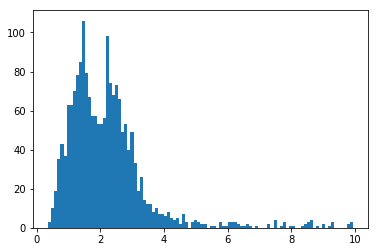

In [10]:
plt.hist(base_kois.corrected_prad[base_kois.corrected_prad<10], 100);

(50, 400)

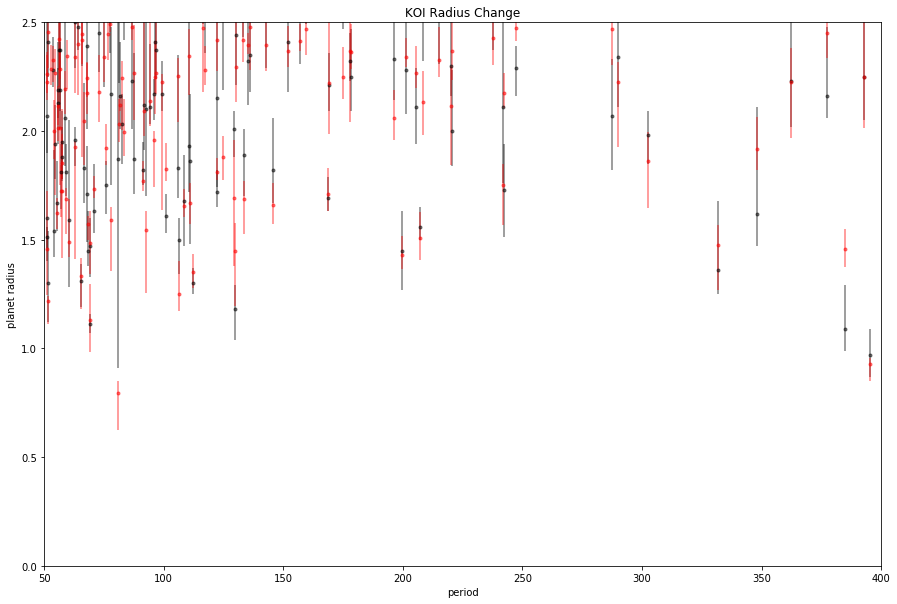

In [11]:
fig, ax = plt.subplots(figsize=(15,10));
ax.errorbar(kois.koi_period, kois.koi_prad, 
            yerr = [-kois.koi_prad_err2, kois.koi_prad_err1],
            fmt="k.", alpha = 0.5);
ax.errorbar(kois.koi_period, kois.corrected_prad, 
            yerr = [-kois.corrected_prad_err2, kois.corrected_prad_err1],
            fmt="r.", alpha = 0.5);

plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Radius Change");
plt.ylim([0, 2.5])
plt.xlim([50, 400])




In [12]:
period = np.linspace(period_rng[0], period_rng[1], n_period)
rp = np.linspace(rp_rng[0], rp_rng[1], n_rp)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
periodShape = period_grid.shape



In [13]:

inputgrid = "../completenessContours/out_sc0_GK_baseline.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
# print "KIC list length" + '{:6d}'.format(kiclist.size)

period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

# interpolate the numerical grids onto the period_grid, rp_grid space
#print("size probtot = " + str(np.shape(probtot)))
#print("size period_want = " + str(np.shape(period_want)))
#print("size rp_want = " + str(np.shape(rp_want)))

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
numProbDetInterp = RectBivariateSpline(period_want, rp_want, probdet)



In [14]:
summedCompleteness = numCompVeInterp(period, rp)
summedProbDet = numProbDetInterp(period, rp)





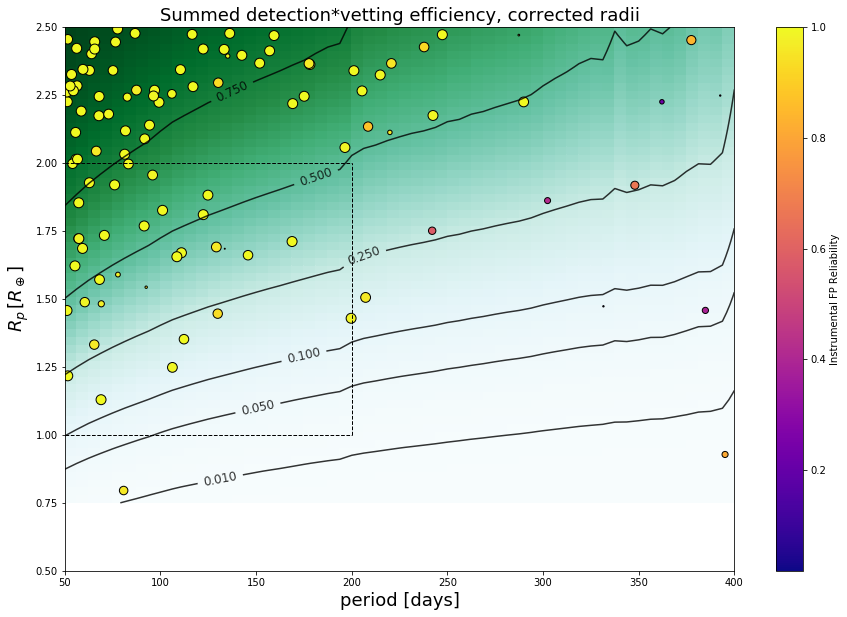

In [15]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
contourLevels = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]


fig, ax = plt.subplots(figsize=(15,10));

plt.pcolor(period_grid, rp_grid, summedProbDet, cmap="BuGn")
c = plt.contour(period_grid, rp_grid, summedProbDet / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
scf = plt.scatter(kois.koi_period, getRadii(kois), cmap="plasma", 
               c=kois.reliability, edgecolors='k', s=100*kois.totalReliability, alpha = 1.0)

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Instrumental FP Reliability");

#c = plt.contour(period_grid, rp_grid, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
plt.ylim(0.5, 2.5)
plt.xlim(50, 400)
plt.clabel(c, fontsize=12, inline=1, fmt="%.3f")
plt.title("Summed detection*vetting efficiency, " + whichRadii + " radii", fontsize = 18)
plt.xlabel("period [days]", fontsize = 18)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 18);
plt.plot([200, 200], [1, 2], color='k', linestyle='--', linewidth=1)
plt.plot([50, 200], [1, 1], color='k', linestyle='--', linewidth=1)
plt.plot([50, 200], [2, 2], color='k', linestyle='--', linewidth=1)
plt.savefig("summedCompleteness.pdf",bbox_inches='tight')





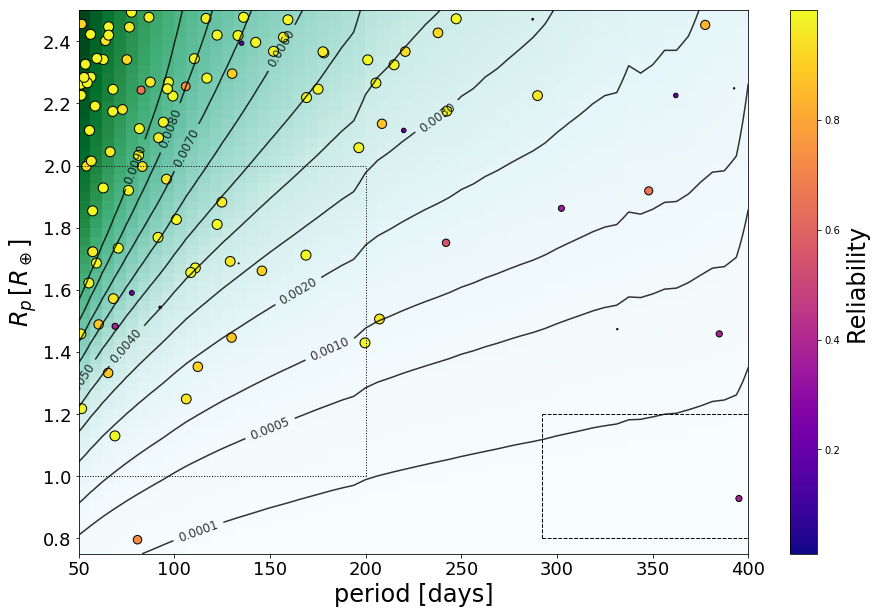

In [16]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
contourLevels = np.arange(1e-3, 1e-2, 1e-3)
contourLevels = np.insert(contourLevels, 0, [1e-4, 5e-4])

fig, ax = plt.subplots(figsize=(15,10));

plt.pcolor(period_grid, rp_grid, summedCompleteness, cmap="BuGn")
c = plt.contour(period_grid, rp_grid, summedCompleteness / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
scf = plt.scatter(kois.koi_period, getRadii(kois), cmap="plasma", 
               c=kois.totalReliability, edgecolors='k', s=100*kois.totalReliability, alpha = 1.0)

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability", fontsize = 24);

#c = plt.contour(period_grid, rp_grid, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
plt.ylim(0.75, 2.5)
plt.xlim(50, 400)
plt.clabel(c, fontsize=12, inline=1, fmt="%.4f")
# plt.title("DR25 PC Average detection*vetting efficiency", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.xlabel("period [days]", fontsize = 24)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 24);
plt.plot([200, 200], [1, 2], color='k', linestyle=':', linewidth=1)
plt.plot([50, 200], [1, 1], color='k', linestyle=':', linewidth=1)
plt.plot([50, 200], [2, 2], color='k', linestyle=':', linewidth=1)
plt.plot([0.8*365, 0.8*365], [0.8, 1.2], color='k', linestyle='--', linewidth=1)
plt.plot([1.2*365, 1.2*365], [0.8, 1.2], color='k', linestyle='--', linewidth=1)
plt.plot([0.8*365, 1.2*365], [0.8, 0.8], color='k', linestyle='--', linewidth=1)
plt.plot([0.8*365, 1.2*365], [1.2, 1.2], color='k', linestyle='--', linewidth=1)
plt.savefig("summedCompleteness.pdf",bbox_inches='tight')




In [17]:
1.2*365

438.0

Compute a basic occurrence rate without reliability

In [18]:
kois = allKois

if model == "dualPowerLaw":
    bounds = [(0, 5), (-5, 5), (-5, 5)]
elif model == "dualPowerLawGap":
    bounds = [(0, 5), (-5, 5), (-5, 5), (0, 5), (0.0, 0.3), (0.2, 0.4), (-0.2, 0.2)]
elif model == "dualPowerLawGapFixedSlope":
    bounds = [(0, 5), (-5, 5), (-5, 5), (0, 5), (0.0, 0.3), (0.2, 0.4)]
elif model == "dualPowerLawFixedValley":
    bounds = [(0, 5), (-5, 5), (-5, 5)]
    
# The ln-likelihood function given at the top of this post.
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(getRadii(kois))
# koi_rps = getRadii(kois)


vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]

theta_0 = initRateModel(model)
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r.x)
ge = plot_results(r.x);



[ 0.56796888 -0.56547296  0.34333841]


/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [19]:
rateModel(365.25, 1.0, period_rng, rp_rng, r.x, model)*365

0.19504586776969884

In [20]:

##################################################################


ndim, nwalkers = len(r.x), nWalkers
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, nBurnin)
sampler.reset()

# Production.
start_time = time.time()
pos, _, _ = sampler.run_mcmc(pos, nMcmc)
print("--- %s seconds ---" % (time.time() - start_time))

kois.to_csv("occurenceRatePosteriors/selectedPcs_noreliability.csv")

samples_noreliability = sampler.flatchain   
np.save("occurenceRatePosteriors/occurenceRatePosteriors_noreliability.npy", samples_noreliability)


--- 24.1645030975 seconds ---


0.22359137477027927


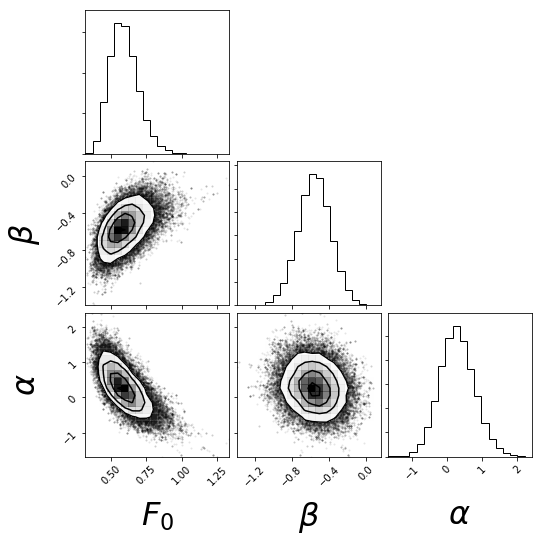

In [21]:
##################################################################
##################################################################

corner.corner(samples_noreliability, labels=getModelLabels(model), label_kwargs = {"fontsize": 32});
plt.savefig("occPostNoReliability.pdf",bbox_inches='tight')

##################################################################

gamma_earth_no_reliability = plot_results(samples_noreliability)
print(np.mean(gamma_earth_no_reliability))

##################################################################



Mean Gamma_Earth = 0.203588132408
Gamma at p=365 days, r=1Re without reliability = 0.206^{+0.106}_{-0.074}


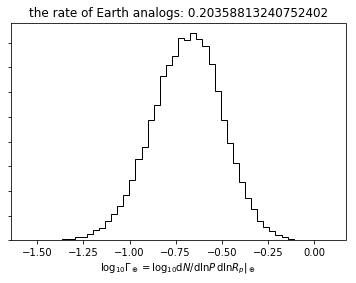

In [22]:

plt.hist(np.log10(gamma_earth_no_reliability), 50, histtype="step", color="k", density=True)
plt.gca().set_yticklabels([])
plt.title("the rate of Earth analogs: " + str(10**np.mean(np.log10(gamma_earth_no_reliability))))
plt.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");

print("Mean Gamma_Earth = {0}".format(10**np.mean(np.log10(gamma_earth_no_reliability))))
print("Gamma at p=365 days, r=1Re without reliability = " + printMedianAndErrorbars(gamma_earth_no_reliability))



In [23]:
print("F = " + printMedianAndErrorbars(samples_noreliability[:,0]))
print("radius exp (alpha) = " + printMedianAndErrorbars(samples_noreliability[:,2]))
print("period exp (beta) = " + printMedianAndErrorbars(samples_noreliability[:,1]))





F = 0.584^{+0.108}_{-0.091}
radius exp (alpha) = 0.275^{+0.503}_{-0.471}
period exp (beta) = -0.556^{+0.172}_{-0.174}


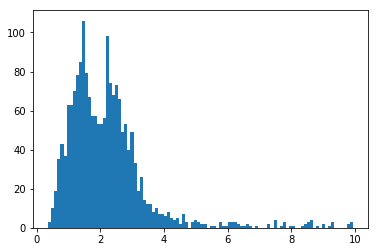

In [24]:
plt.hist(base_kois.corrected_prad[base_kois.corrected_prad<10], 100);

In [25]:
nTrials = 1000

f = FloatProgress(min=0, max=nTrials)
display(f)
koiRadii0 = getRadii(base_kois)
periodSelect = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])

for mCount in range(nTrials):
    # randomly change the koi radius
    # randomly choose half to be modified w/ upper error, half w/ lower error
    errorSelect = np.random.rand(len(base_kois)) < 0.5
    # add the sampled error to the radii
    # upper error bar
    thisRadii = np.zeros(koiRadii0.shape)
    thisRadii[errorSelect] = koiRadii0[errorSelect] \
                   + np.abs(np.random.normal(0.0, base_kois['corrected_prad_err1'][errorSelect], sum(errorSelect)))
    # lower error bar
    thisRadii[~errorSelect] = koiRadii0[~errorSelect] \
                   - np.abs(np.random.normal(0.0, -base_kois['corrected_prad_err2'][~errorSelect], sum(~errorSelect)))
    # select on period and radius in range
    m = periodSelect & np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
    koi_periods = np.array(base_kois[m].koi_period)
    koi_rps = np.array(thisRadii[m])

    theta_0 = initRateModel(model)
    r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)

    ##################################################################


    ndim, nwalkers = len(r.x), 2*len(r.x)
    pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

    # Burn in.
    pos, _, _ = sampler.run_mcmc(pos, 400)
    sampler.reset()

    # Production.
    pos, _, _ = sampler.run_mcmc(pos, 2000)

    samples = sampler.flatchain   
    if mCount == 0:
        samplesRadiiSigma = samples[:-1:10,:]
        allRadii = koi_rps;
        allRadii0 =  koiRadii0[m];
    else:
        samplesRadiiSigma = np.concatenate((samplesRadiiSigma, samples[:-1:10,:]))
        allRadii = np.concatenate((allRadii, koi_rps))
        allRadii0 = np.concatenate((allRadii0, koiRadii0[m]))
    
    f.value += 1



FloatProgress(value=0.0, max=1000.0)

/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


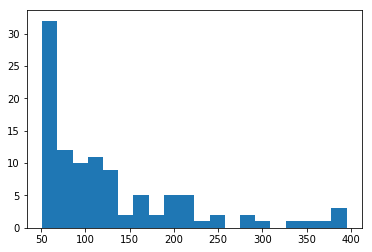

In [26]:
plt.hist(koi_periods, 20);


107264

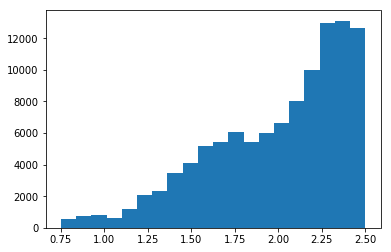

In [27]:
plt.hist(allRadii, 20);
len(allRadii)


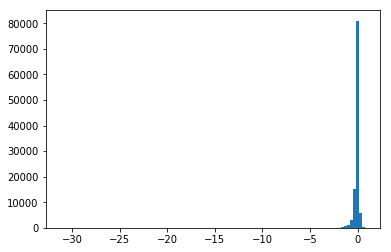

In [28]:
plt.hist(allRadii - allRadii0, 100);

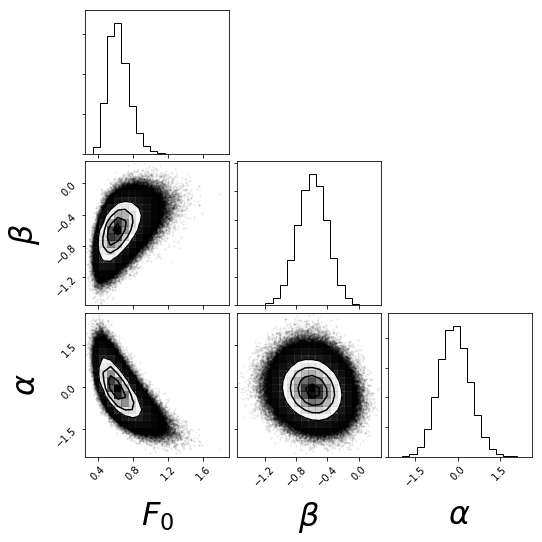

In [29]:
corner.corner(samplesRadiiSigma, labels=getModelLabels(model), label_kwargs = {"fontsize": 32});
gamma_earth_samplesRadiiSigma = plot_results(samplesRadiiSigma)


Mean Gamma_Earth = 0.203588132408
Gamma at p=365 days, r=1Re without reliability, no uncertainty = 0.206^{+0.106}_{-0.074}
Mean Gamma_Earth = 0.251707747419
Gamma at p=365 days, r=1Re without reliability, rp uncertainty = 0.254^{+0.144}_{-0.095}


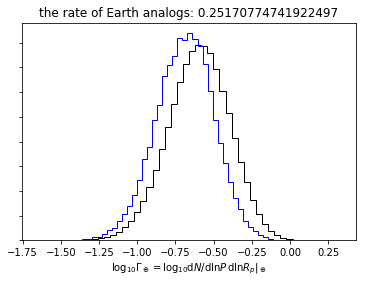

In [30]:

plt.hist(np.log10(gamma_earth_samplesRadiiSigma), 50, histtype="step", color="k", density=True)
plt.hist(np.log10(gamma_earth_no_reliability), 50, histtype="step", color="b", density=True)
plt.gca().set_yticklabels([])
plt.title("the rate of Earth analogs: " + str(10**np.mean(np.log10(gamma_earth_samplesRadiiSigma))))
plt.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");

print("Mean Gamma_Earth = {0}".format(10**np.mean(np.log10(gamma_earth_no_reliability))))
print("Gamma at p=365 days, r=1Re without reliability, no uncertainty = " + printMedianAndErrorbars(gamma_earth_no_reliability))
print("Mean Gamma_Earth = {0}".format(10**np.mean(np.log10(gamma_earth_samplesRadiiSigma))))
print("Gamma at p=365 days, r=1Re without reliability, rp uncertainty = " + printMedianAndErrorbars(gamma_earth_samplesRadiiSigma))




In [31]:
modelLabels = getModelLabels(model)
for i in range(0,ndim):
    print("MCMC with uncertainty " + modelLabels[i] + "=" + printMedianAndErrorbars(samplesRadiiSigma[:,i]))
for i in range(0,ndim):
    print("MCMC no reliability " + modelLabels[i] + "=" + printMedianAndErrorbars(samples_noreliability[:,i]))


MCMC with uncertainty $F_0$=0.625^{+0.132}_{-0.105}
MCMC with uncertainty $\beta$=-0.592^{+0.186}_{-0.191}
MCMC with uncertainty $\alpha$=-0.120^{+0.550}_{-0.527}
MCMC no reliability $F_0$=0.584^{+0.108}_{-0.091}
MCMC no reliability $\beta$=-0.556^{+0.172}_{-0.174}
MCMC no reliability $\alpha$=0.275^{+0.503}_{-0.471}


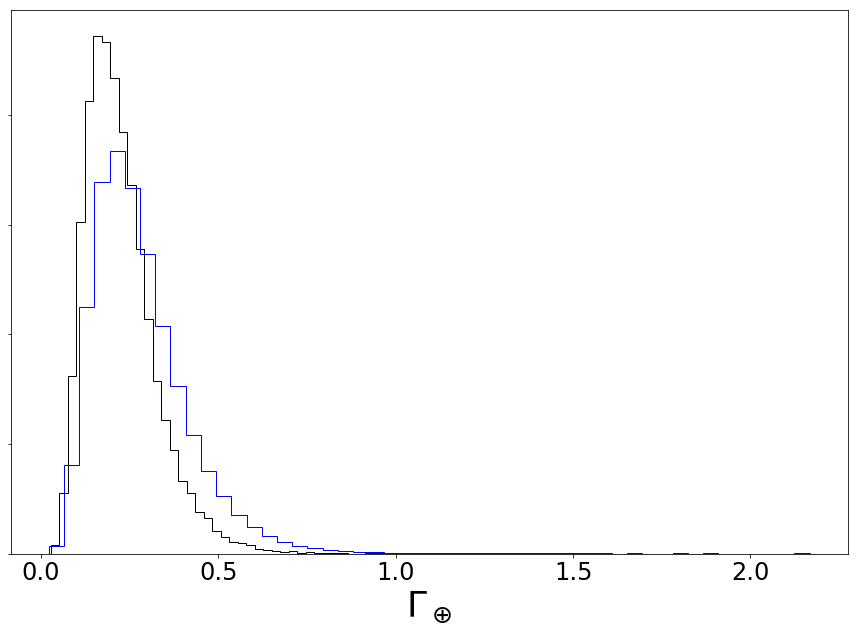

In [32]:
plt.figure(figsize=(15,10));
plt.hist(gamma_earth_no_reliability, 50, histtype="step", color="k", density=True)
plt.hist(gamma_earth_samplesRadiiSigma, 50, histtype="step", color="b", density=True)
plt.gca().set_yticklabels([])
plt.xlabel(r"$\Gamma_\oplus$", fontSize = 36);
plt.tick_params(labelsize = 24)
plt.savefig("gammaDist_rp_sigma.pdf",bbox_inches='tight')


In [33]:
F1Dist_nr = integrateRateModel([50.,200.], [1., 2.], samples_noreliability, model)
print("1-2Re, 50-200 Days without reliability = " + printMedianAndErrorbars(F1Dist_nr))

F1Dist_nr_sigma = integrateRateModel([50.,200.], [1., 2.], samplesRadiiSigma[:-1:10,:], model)
print("1-2Re, 50-200 Days without reliability with rp uncertainty = " + printMedianAndErrorbars(F1Dist_nr_sigma))



FloatProgress(value=0.0, max=80000.0)

1-2Re, 50-200 Days without reliability = 0.183^{+0.033}_{-0.029}


FloatProgress(value=0.0, max=120000.0)

1-2Re, 50-200 Days without reliability with rp uncertainty = 0.203^{+0.039}_{-0.034}


In [34]:
print("1-2Re, 50-200 Days without reliability = " + printMedianAndErrorbars(F1Dist_nr))
print("1-2Re, 50-200 Days without reliability with rp uncertainty = " + printMedianAndErrorbars(F1Dist_nr_sigma))


1-2Re, 50-200 Days without reliability = 0.183^{+0.033}_{-0.029}
1-2Re, 50-200 Days without reliability with rp uncertainty = 0.203^{+0.039}_{-0.034}


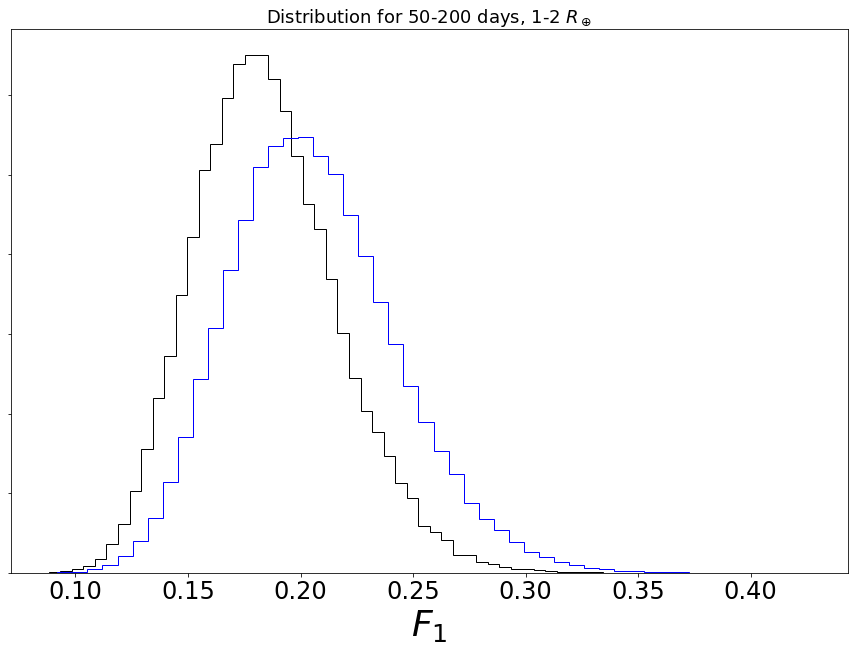

In [35]:
plt.figure(figsize=(15,10));
greyLevel = "0.7"
plt.hist(F1Dist_nr, 50, histtype="step", color="k", density=True);
plt.hist(F1Dist_nr_sigma, 50, histtype="step", color="b", density=True);
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.xlabel(r"$F_1$", fontSize = 36);
plt.savefig("f1Dist_rp_sigma.pdf",bbox_inches='tight')
plt.title("Distribution for 50-200 days, 1-2 $R_\oplus$", fontsize=18);



In [36]:
zetaDist_nr = integrateRateModel([.8*365.25,1.2*365.25], 
                              [0.8,1.2], samples_noreliability, model)
print("zeta Earth without reliability = " + printMedianAndErrorbars(zetaDist_nr))

zetaDist_nr_sigma = integrateRateModel([.8*365.25,1.2*365.25], 
                              [0.8,1.2], samplesRadiiSigma[:-1:10,:], model)
print("zeta Earth without reliability with rp uncertainty = " + printMedianAndErrorbars(zetaDist_nr_sigma))


FloatProgress(value=0.0, max=80000.0)

zeta Earth without reliability = 0.033^{+0.017}_{-0.012}


FloatProgress(value=0.0, max=120000.0)

zeta Earth without reliability with rp uncertainty = 0.041^{+0.024}_{-0.015}


In [37]:
print("zeta Earth without reliability = " + printMedianAndErrorbars(zetaDist_nr))
print("zeta Earth without reliability with rp uncertainty = " + printMedianAndErrorbars(zetaDist_nr_sigma))


zeta Earth without reliability = 0.033^{+0.017}_{-0.012}
zeta Earth without reliability with rp uncertainty = 0.041^{+0.024}_{-0.015}


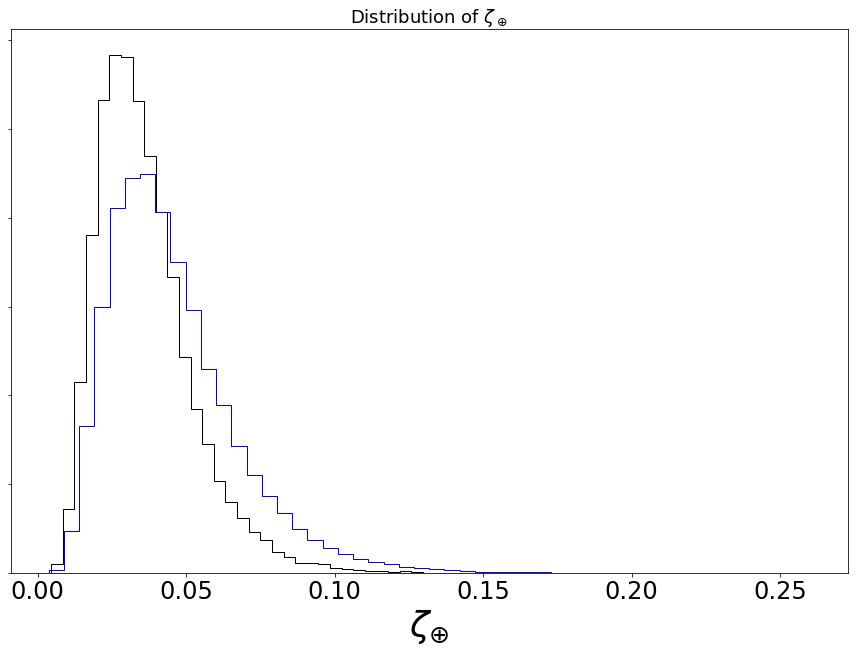

In [38]:
plt.figure(figsize=(15,10));
plt.hist(zetaDist_nr, 50, histtype="step", color="k", density=True);
plt.hist(zetaDist_nr_sigma, 50, histtype="step", color="b", density=True);
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.xlabel(r"$\zeta_{\oplus}$", fontSize = 36);
plt.savefig("zetaEarthDist_rp_sigma.pdf",bbox_inches='tight')
plt.title("Distribution of $\zeta_\oplus$", fontsize=18);


Compute an occurrence rate with reliability

In [39]:
import sys
sys.path.insert(0, '..')
import dr25Models as funcModels

nTrials = 1000

f = FloatProgress(min=0, max=nTrials)
display(f)

# start over
base_kois = pd.read_csv(pcCatalog)
m = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])
thisRadii = getRadii(base_kois)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
kois = pd.DataFrame(base_kois[m])
allKois = kois

# read the posteriors
# set the effectiveness model
fpEffModel = "rotatedLogisticX0"
# set the obs FP rate model
obsModel = "rotatedLogisticX0"
eSamples = np.load("binEffPosteriors_" + str(fpEffModel) + ".npy");
oSamples = np.load("binObsPosteriors_" + str(obsModel) + ".npy");

# read in the model parameters
tt = pd.read_pickle("fpEffectivenessTable.pkl")
tm = tt[tt.Model == fpEffModel]
fpEffXRange = tm.periodRange.values[0]
fpEffYRange = tm.mesRange.values[0]
fpEffTheta = tm.medianMCMCTheta.values[0] 

tt = pd.read_pickle("obsFpTable.pkl")
tm = tt[tt.Model == obsModel]
obsXRange = tm.periodRange.values[0]
obsYRange = tm.mesRange.values[0]
obsTheta = tm.medianMCMCTheta.values[0] 

for mCount in range(nTrials):
    # randomly select kois
    # recompute the reliability with draw from posteriors
    fpEffectiveness = funcModels.evaluateModel(allKois.koi_period,
                                 allKois.koi_max_mult_ev, eSamples[np.random.randint(len(eSamples)),:], 
                                 fpEffXRange, fpEffYRange, fpEffModel)
    obsFpRate = funcModels.evaluateModel(allKois.koi_period,
                                 allKois.koi_max_mult_ev, oSamples[np.random.randint(len(eSamples)),:], 
                                 obsXRange, obsYRange, obsModel)

    faReliability = 1-(obsFpRate/(1-obsFpRate))*(1-fpEffectiveness)/fpEffectiveness
    
    faReliability[faReliability < 0.] = 0.  
    totalReliability = faReliability * (1 - allKois.fpp_prob_use)
    
    koiSelect = (np.random.rand(len(allKois)) < totalReliability)
    kois = allKois[koiSelect]
#    print(str(mCount) + " of " + str(nTrials) + ", selected " + str(len(kois)) 
#          + " kois out of " + str(len(allKois)) + " after reliability cut")
    
    koi_periods = np.array(kois.koi_period)
    koi_rps = np.array(getRadii(kois))

    theta_0 = initRateModel(model)
    r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)

    ##################################################################


    ndim, nwalkers = len(r.x), 2*len(r.x)
    pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

    # Burn in.
    pos, _, _ = sampler.run_mcmc(pos, 400)
    sampler.reset()

    # Production.
    pos, _, _ = sampler.run_mcmc(pos, 2000)

    samples = sampler.flatchain   
    if mCount == 0:
        samplesReliabilitySigma = samples[:-1:10,:]
        allReliability = totalReliability;
    else:
        samplesReliabilitySigma = np.concatenate((samplesReliabilitySigma, samples[:-1:10,:]))
        allReliability = np.vstack((allReliability, totalReliability))
    
    f.value += 1



FloatProgress(value=0.0, max=1000.0)

/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


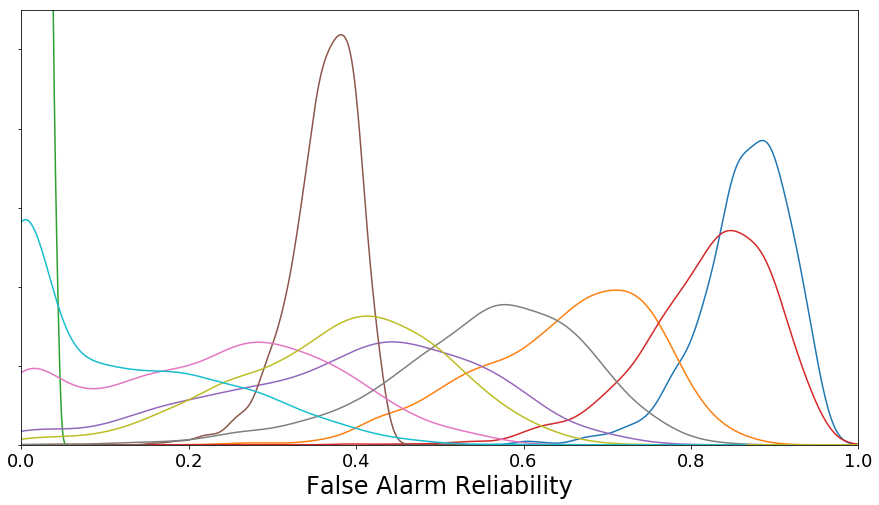

In [41]:
ii = (allKois["reliability"]<0.9)
ar = pd.DataFrame(allReliability[:,ii])
ax = ar.plot.kde(legend = False, fontsize = 18, figsize = (15,8))

plt.ylim(0,11)
plt.xlim(0,1)
plt.gca().set_yticklabels([])
plt.xlabel("False Alarm Reliability", fontsize = 24)
plt.ylabel("")
plt.savefig("reliabilityUncertaintyDist.pdf",bbox_inches='tight')


In [42]:
allKois["reliability"].iloc[0]

0.9998968584086352

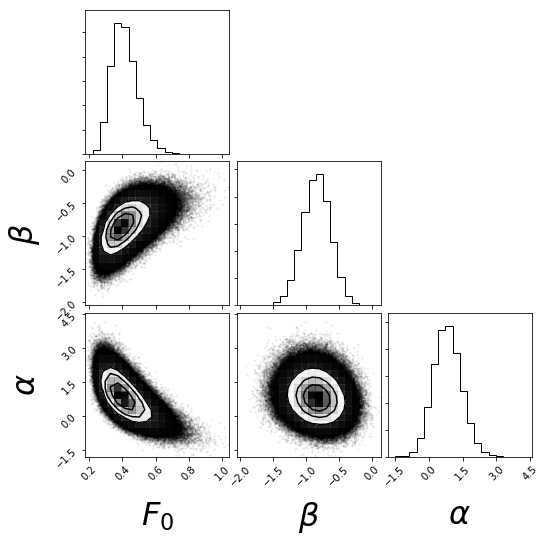

In [43]:
corner.corner(samplesReliabilitySigma, labels=getModelLabels(model), label_kwargs = {"fontsize": 32});




In [44]:
modelLabels = getModelLabels(model)
for i in range(0,ndim):
    print("MCMC with reliability " + modelLabels[i] + "=" + printMedianAndErrorbars(samplesReliabilitySigma[:,i]))


MCMC with reliability $F_0$=0.406^{+0.085}_{-0.068}
MCMC with reliability $\beta$=-0.840^{+0.208}_{-0.215}
MCMC with reliability $\alpha$=0.814^{+0.628}_{-0.590}


In [45]:
gamma_earth = plot_results(samplesReliabilitySigma)


In [46]:
gamma_earth_no_sigma = np.load("gammaDistReliability.npy", )
F1Dist_no_sigma = np.load("f1DistReliability.npy")
zetaDist_no_sigma = np.load("zetaDistReliability.npy")


Text(0.5,1,'the rate of Earth analogs: 0.086/0.206')

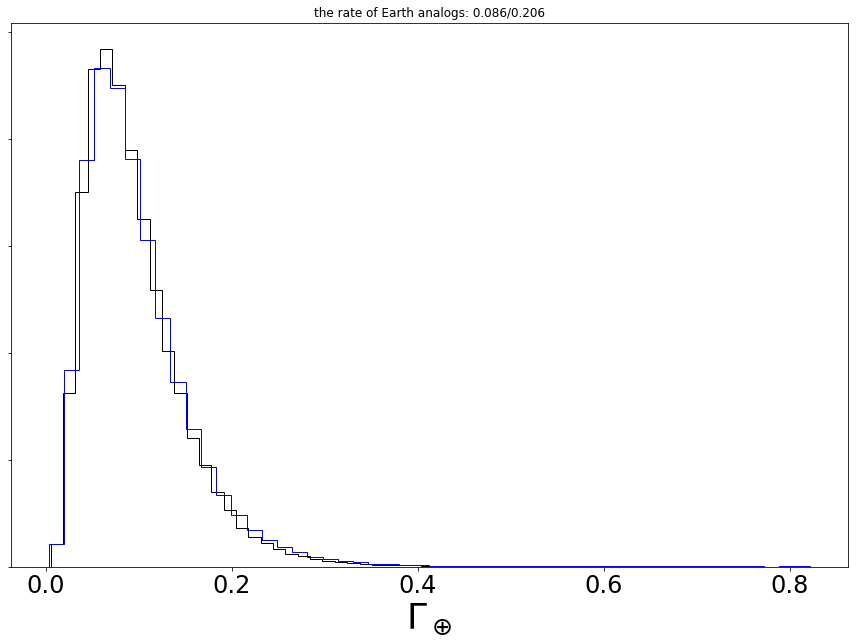

In [47]:
plt.figure(figsize=(15,10));
plt.hist(gamma_earth_no_sigma, 50, histtype="step", color="k", density=True)
plt.hist(gamma_earth, 50, histtype="step", color="b", density=True)
plt.gca().set_yticklabels([])
plt.xlabel(r"$\Gamma_\oplus$", fontSize = 36);
plt.tick_params(labelsize = 24)
plt.savefig("gammaDist_reliabilityUncertainty.pdf",bbox_inches='tight')
plt.title("the rate of Earth analogs: " + str(round(np.median(gamma_earth), 3))
    + "/" + str(round(np.median(gamma_earth_no_reliability), 3)))




In [48]:
print("Gamma at p=365 days, r=1Re = " + printMedianAndErrorbars(gamma_earth))



Gamma at p=365 days, r=1Re = 0.086^{+0.062}_{-0.037}


In [49]:
F1Dist = integrateRateModel([50.,200.], [1., 2.], samplesReliabilitySigma[:-1:10,:], model)


FloatProgress(value=0.0, max=120000.0)

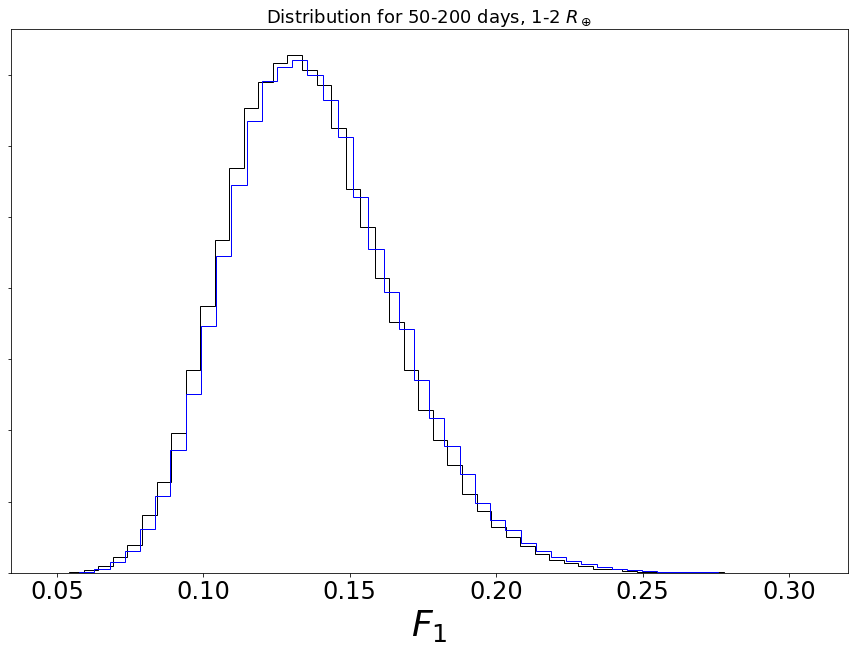

In [50]:
plt.figure(figsize=(15,10));
greyLevel = "0.7"
plt.hist(F1Dist_no_sigma, 50, histtype="step", color="k", density=True);
plt.hist(F1Dist, 50, histtype="step", color="b", density=True);
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.xlabel(r"$F_1$", fontSize = 36);
plt.savefig("f1Dist_reliabilityUncertainty.pdf",bbox_inches='tight')
plt.title("Distribution for 50-200 days, 1-2 $R_\oplus$", fontsize=18);




In [51]:

print("1-2Re, 50-200 Days = " + printMedianAndErrorbars(F1Dist))



1-2Re, 50-200 Days = 0.136^{+0.030}_{-0.026}


In [52]:
zetaDist = integrateRateModel([.8*365.25,1.2*365.25], 
                              [0.8,1.2], samplesReliabilitySigma[:-1:10,:], model)


FloatProgress(value=0.0, max=120000.0)

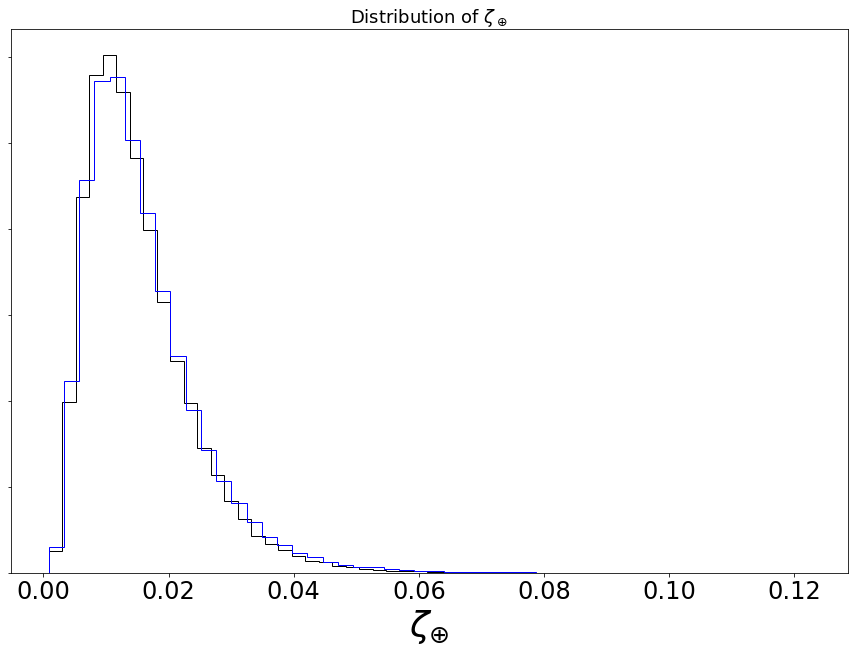

In [53]:
plt.figure(figsize=(15,10));
plt.hist(zetaDist_no_sigma, 50, histtype="step", color="k", density=True);
plt.hist(zetaDist, 50, histtype="step", color="b", density=True);
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.xlabel(r"$\zeta_{\oplus}$", fontSize = 36);
plt.savefig("zetaEarthDist_reliabilityUncertainty.pdf",bbox_inches='tight')
plt.title("Distribution of $\zeta_\oplus$", fontsize=18);



In [54]:
print("zeta-Earth = " + printMedianAndErrorbars(zetaDist))





zeta-Earth = 0.014^{+0.010}_{-0.006}


In [55]:
np.save("samples_noreliability.npy", samples_noreliability)
np.save("samplesRadiiSigma.npy", samplesRadiiSigma)
np.save("samplesReliabilitySigma.npy", samplesReliabilitySigma)


In [64]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [65]:
%%bash -s  "$model"
jupyter nbconvert --to html computeOccurrence.ipynb
mv computeOccurrence.html htmlArchive/computeOccurrence_$1.html

[NbConvertApp] Converting notebook computeOccurrence.ipynb to html
[NbConvertApp] Writing 1435979 bytes to computeOccurrence.html


In [58]:
errorSelect = np.random.rand(len(allKois)) < 0.5
               

In [59]:
sum(errorSelect)

60

In [60]:
sum(~errorSelect)

48

In [61]:
sum(errorSelect)+sum(~errorSelect)

108

In [62]:
len(gamma_earth_no_reliability)

80000

In [63]:
samples_noreliability.shape

(80000, 3)